### 1. ****Import Libraries****

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


### 2. ****Dataset Paths & Params****

In [2]:
DATA_DIR = "../data/processed"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10


### 3. ****Data Generator****

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 2464 images belonging to 7 classes.
Found 612 images belonging to 7 classes.


### 4. ****Load Base Model****

In [5]:

# Load MobileNet base model
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

print("Base model loaded successfully!")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step
Base model loaded successfully!


### 5. ****Add Custom Layers****

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)

output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 6. ****Compile Model****

In [7]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Transfer learning model compiled!")


Transfer learning model compiled!


### 7. ****Train Model****

In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


c:\Users\Damod\anaconda3\envs\crop_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4707 - loss: 1.4004 - val_accuracy: 0.4886 - val_loss: 1.3663
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7341 - loss: 0.7369 - val_accuracy: 0.5670 - val_loss: 1.2028
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8050 - loss: 0.5698 - val_accuracy: 0.5376 - val_loss: 1.3104
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.8514 - loss: 0.4444 - val_accuracy: 0.5735 - val_loss: 1.2140
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.8791 - loss: 0.3734 - val_accuracy: 0.5948 - val_loss: 1.1795
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9049 - loss: 0.2959 - val_accuracy: 0.5817 - val_loss: 1.1962
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9233 - loss: 0.2556 - val_accuracy: 0.5915 - val_loss: 1.2029
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9549 - loss: 0.1909 - val_accuracy: 0.5752 - v

### 8. ****Plot Accuracy****

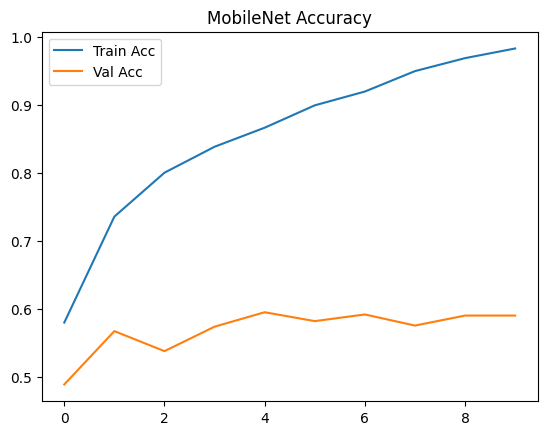

In [11]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("MobileNet Accuracy")
plt.legend()
plt.savefig("../results/accuracy_loss.png")
plt.show()



### 9. ****Save Model****

In [10]:
model.save("../models/mobilenet_model.h5")
print("MobileNet model saved successfully!")


MobileNet model saved successfully!
